In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

### `Load data numerical, categorical and target`

In [ ]:
numericals = pd.read_csv('files_for_lab/numerical.csv')
categoricals = pd.read_csv('files_for_lab/categorical.csv')
targets = pd.read_csv('files_for_lab/target.csv')

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")
print(f"Targets shape: {targets.shape}")

In [ ]:
important_columns = ['WEALTH1', 'WEALTH2', 'VETERANS', 'SOLIH']

### `Numericals - Variance Threshold`

In [ ]:
min_max_scaler = MinMaxScaler()
numericals_scaled = min_max_scaler.fit_transform(numericals)

In [ ]:
selector = VarianceThreshold(0.09)
selected_numericals = selector.fit_transform(numericals_scaled)

columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, selector.get_support()) if col_tuple[1] == False]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_variance = numericals.drop(columns_to_drop, axis=1)
numericals_variance.shape

In [ ]:
# Save results to csv

numericals_variance.to_csv('numericals_cleaned/numericals_variance.csv')

In [ ]:
numericals_variance_manual_drop = numericals_variance.drop(['POP90C3', 'HC6', 'HC7', 'CLUSTER2'], axis=1)
numericals_variance_manual_drop.shape

In [ ]:
# Save results to csv

numericals_variance_manual_drop.to_csv('numericals_cleaned/numericals_variance_manual_drop.csv')

### `Numericals - Chi2`

In [ ]:
selector = SelectKBest(chi2, k=10)
selector.fit(numericals_scaled, targets[['TARGET_B']])
mask = selector.get_support()
columns_to_drop = numericals.columns[~mask]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_chi2 = numericals.drop(columns_to_drop, axis=1)
numericals_chi2.shape

In [ ]:
# Save results to csv

numericals_chi2.to_csv('numericals_cleaned/numericals_chi2.csv')

### `Numericals - RFE`

In [ ]:
model = LinearRegression()

# Create an instance of the RFE class
rfe = RFE(model, n_features_to_select=25, verbose=False)

# Fit the RFE to the DataFrame
rfe.fit(numericals_scaled, targets[['TARGET_B']])

# Get the boolean mask of the selected columns
mask = rfe.support_

# Use the mask to obtain the names of the selected columns
columns_to_drop = numericals.columns[~mask]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_rfe = numericals.drop(columns_to_drop, axis=1)
numericals_rfe.shape

In [ ]:
# Save results to csv

numericals_rfe.to_csv('numericals_cleaned/numericals_rfe.csv')

In [ ]:
numericals_rfe_manual_drop = numericals_rfe.drop(['POP90C1', 'DW1', 'MC2'], axis=1)
numericals_rfe_manual_drop.shape

In [ ]:
# Save results to csv

numericals_rfe_manual_drop.to_csv('numericals_cleaned/numericals_rfe_manual_drop.csv')

### `Numericals - OLS`

In [ ]:
df = sm.add_constant(numericals_scaled)

# Fit the OLS model
model = sm.OLS(targets[['TARGET_B']], df)
results = model.fit()

# Get the p-values of the features
pvalues = results.pvalues

# Select the features with a p-value more than 0.05
columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, pvalues[1::]) if col_tuple[1] > 0.05]
print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_ols = numericals.drop(columns_to_drop, axis=1)
numericals_ols.shape

In [ ]:
# Save results to csv

numericals_ols.to_csv('numericals_cleaned/numericals_ols.csv')

### `Categoricals`

In [ ]:
object_columns_from_categoricals = [col for col in categoricals.columns if categoricals[col].dtype == object]
for col in object_columns_from_categoricals:
    categoricals[col] = pd.factorize(categoricals[col])[0]

In [ ]:
# 'RFA_2R' has only 1 unique value so we can drop it

categoricals.drop('RFA_2R', axis=1, inplace=True)
categoricals.shape

In [ ]:
# Save results to csv

categoricals.to_csv('categoricals_cleaned/categoricals.csv')

### `Load cached data`

In [2]:
numericals = pd.read_csv('files_for_lab/numerical.csv')
numericals_variance = pd.read_csv('numericals_cleaned/numericals_variance.csv')
numericals_variance_manual_drop = pd.read_csv('numericals_cleaned/numericals_variance_manual_drop.csv')
numericals_chi2 = pd.read_csv('numericals_cleaned/numericals_chi2.csv')
numericals_rfe = pd.read_csv('numericals_cleaned/numericals_rfe.csv')
numericals_rfe_manual_drop = pd.read_csv('numericals_cleaned/numericals_rfe_manual_drop.csv')
numericals_ols = pd.read_csv('numericals_cleaned/numericals_ols.csv')

categoricals = pd.read_csv('categoricals_cleaned/categoricals.csv')

targets = pd.read_csv('files_for_lab/target.csv')

### `Check accuracy with sets of selected columns`

#### `Helper functions`

In [11]:
def oversample(selector_dataframe):
    target = targets[['TARGET_B']]

    target_b_0 = target[target['TARGET_B'] == 0]
    target_b_1 = target[target['TARGET_B'] == 1]

    target_b_1_oversampled = resample(target_b_1, replace=True, n_samples=len(target_b_0))
    target_b_oversampled = pd.concat([target_b_0, target_b_1_oversampled], axis=0)

    full_df = pd.concat([target_b_oversampled, selector_dataframe, categoricals], axis=1).sample(frac=1, random_state=10)

    return full_df['TARGET_B'], full_df.drop('TARGET_B', axis=1)


def score_selected_columns(selectors, should_oversample):
    for selector in selectors:

        print(f"====== {selector['name']} ======")

        full_df = pd.concat([targets[['TARGET_B']], selector['dataframe'], categoricals], axis=1).sample(frac=1, random_state=10)

        y = full_df['TARGET_B']
        X = full_df.drop('TARGET_B', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

        if should_oversample == True:
            y_train, X_train = oversample(selector['dataframe'])

        # Scaling data = X_train
        X_train_transformer = MinMaxScaler().fit(X_train)
        X_train_normalized = X_train_transformer.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_transformer = MinMaxScaler().fit(X_test)
        X_test_normalized = X_test_transformer.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        # Create an instance of the RandomForestClassifier
        clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf=20)

        # Fit the classifier to the training data
        clf.fit(X_train_normalized, y_train)

        # Make predictions on the test data
        y_pred = clf.predict(X_test_normalized)

        # Calculate the accuracy of the model        
        scores = cross_val_score(clf, X_train_normalized, y_train, cv=10)
        # Print the mean and standard deviation of the scores
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"accuracy: {accuracy}")
        print("precision: ",precision_score(y_test, y_pred, zero_division=0))
        print("recall: ",recall_score(y_test, y_pred))
        print("f1: ",f1_score(y_test, y_pred))

        # create confusion matrix
        matrix = confusion_matrix(y_test, y_pred)

        # display confusion matrix
        plt.imshow(matrix, cmap='Blues')
        plt.colorbar()
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        # set tick marks for x-axis and y-axis
        plt.xticks([0,1])
        plt.yticks([0,1])
        # set the tick labels for x-axis and y-axis
        plt.xticks(ticks=[0,1], labels=['Negative', 'Positive'])
        plt.yticks(ticks=[0,1], labels=['Negative', 'Positive'])

        # loop through the cells of the matrix and add the values
        for i in range(2):
            for j in range(2):
                plt.text(j, i, matrix[i, j], ha='center', va='center', color='black', fontsize=20)
        plt.show()

        print("================================")

#### `With imbalanced label`

In [12]:
selectors = [
    {'name': 'numericals', 'dataframe': numericals},
    {'name': 'numericals_variance', 'dataframe': numericals_variance},
    {'name': 'numericals_variance_manual_drop', 'dataframe': numericals_variance_manual_drop},
    {'name': 'numericals_chi2', 'dataframe': numericals_chi2},
    {'name': 'numericals_rfe', 'dataframe': numericals_rfe},
    {'name': 'numericals_rfe_manual_drop', 'dataframe': numericals_rfe_manual_drop},
    {'name': 'numericals_ols', 'dataframe': numericals_ols},
]

====== numericals ======
Accuracy: 0.95 (+/- 0.00)
accuracy: 0.9467588953518838
precision:  0.0
recall:  0.0
f1:  0.0


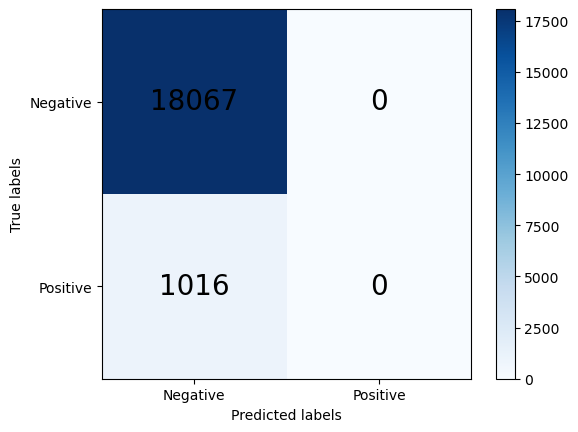

====== numericals_variance ======
Accuracy: 0.95 (+/- 0.00)
accuracy: 0.9467588953518838
precision:  0.0
recall:  0.0
f1:  0.0


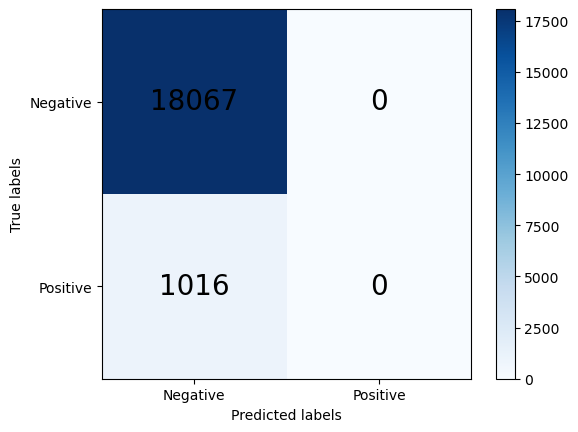

====== numericals_variance_manual_drop ======
Accuracy: 0.95 (+/- 0.00)
accuracy: 0.9467588953518838
precision:  0.0
recall:  0.0
f1:  0.0


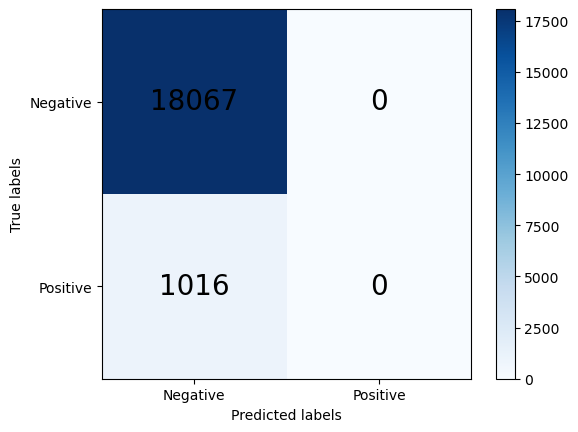

====== numericals_chi2 ======
Accuracy: 0.95 (+/- 0.00)
accuracy: 0.9467588953518838
precision:  0.0
recall:  0.0
f1:  0.0


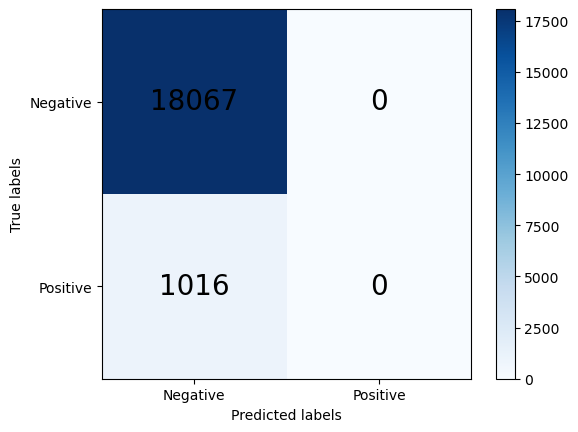

====== numericals_rfe ======
Accuracy: 0.95 (+/- 0.00)
accuracy: 0.9467588953518838
precision:  0.0
recall:  0.0
f1:  0.0


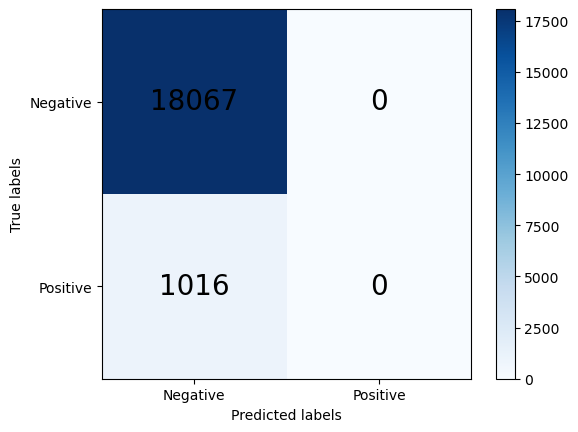

====== numericals_rfe_manual_drop ======
Accuracy: 0.95 (+/- 0.00)
accuracy: 0.9467588953518838
precision:  0.0
recall:  0.0
f1:  0.0


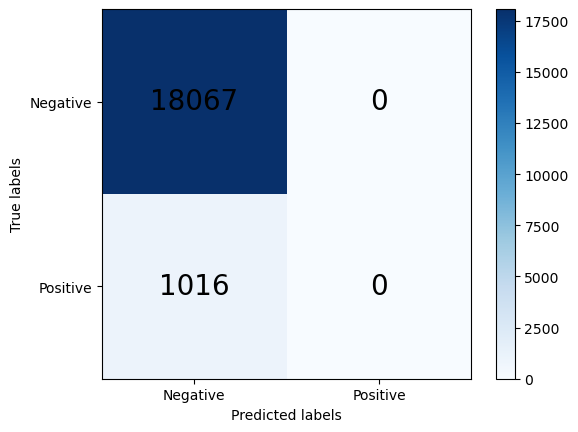

====== numericals_ols ======
Accuracy: 0.95 (+/- 0.00)
accuracy: 0.9467588953518838
precision:  0.0
recall:  0.0
f1:  0.0


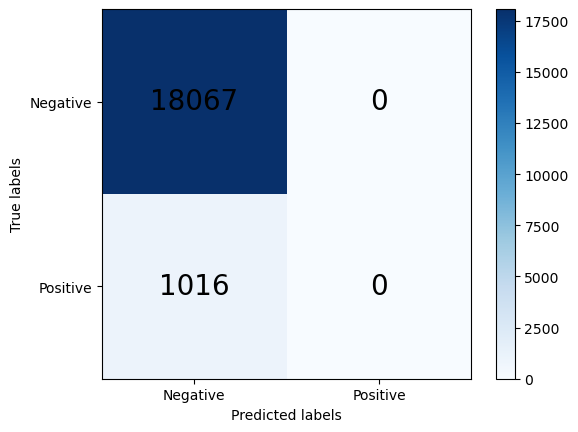

In [13]:
score_selected_columns(selectors=selectors, should_oversample=False)

#### `With Oversampling`

====== numericals ======
Accuracy: 0.61 (+/- 0.01)
accuracy: 0.7361525965519048
precision:  0.09494053618222133
recall:  0.46358267716535434
f1:  0.15760414923874852


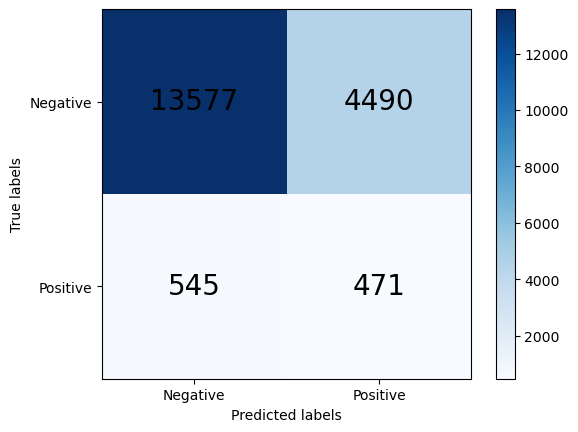

====== numericals_variance ======
Accuracy: 0.60 (+/- 0.01)
accuracy: 0.6020541843525651
precision:  0.07908881494753008
recall:  0.6082677165354331
f1:  0.13997734994337488


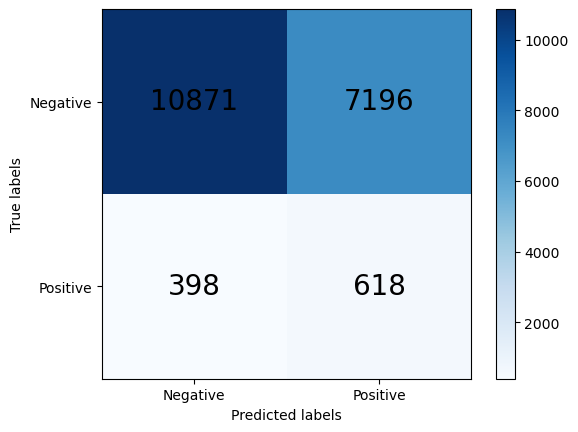

====== numericals_variance_manual_drop ======
Accuracy: 0.60 (+/- 0.01)
accuracy: 0.5944033956925012
precision:  0.078168130489335
recall:  0.6131889763779528
f1:  0.13866013799243268


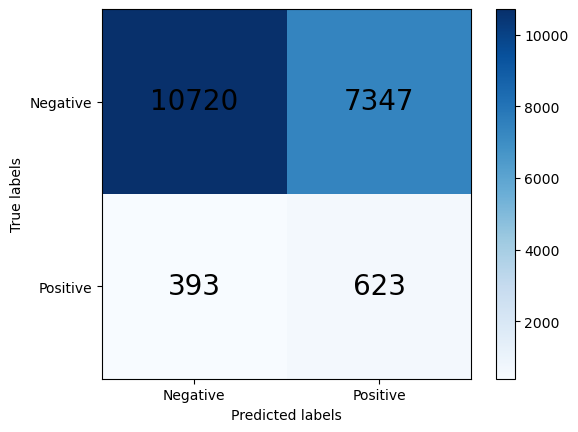

====== numericals_chi2 ======
Accuracy: 0.60 (+/- 0.01)
accuracy: 0.5963422941885448
precision:  0.07927519818799547
recall:  0.6200787401574803
f1:  0.14057793149615086


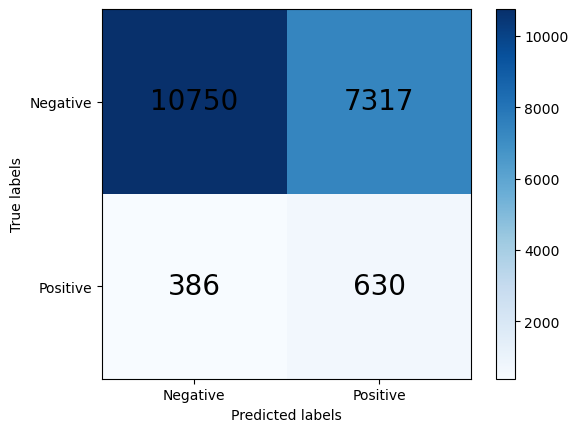

====== numericals_rfe ======
Accuracy: 0.59 (+/- 0.01)
accuracy: 0.8398574647592097
precision:  0.0987411487018096
recall:  0.2470472440944882
f1:  0.14109050028105677


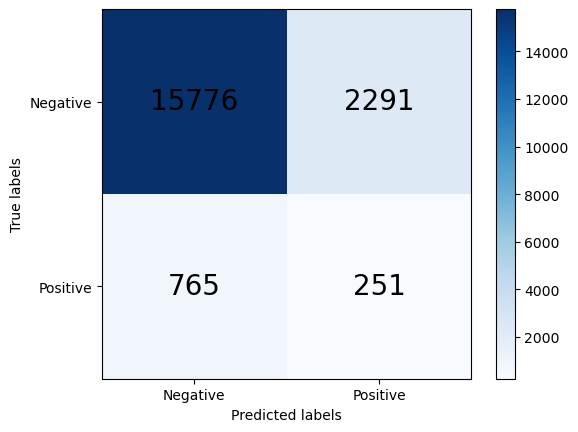

====== numericals_rfe_manual_drop ======
Accuracy: 0.59 (+/- 0.01)
accuracy: 0.8320494681129801
precision:  0.09923105089710729
recall:  0.26673228346456695
f1:  0.14464905257539365


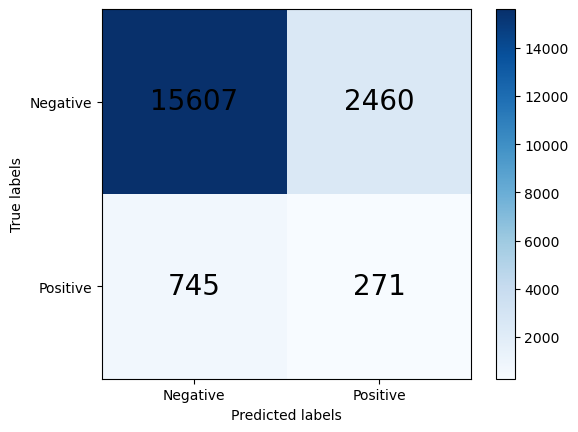

====== numericals_ols ======
Accuracy: 0.60 (+/- 0.01)
accuracy: 0.6787716816014253
precision:  0.0799934296977661
recall:  0.4793307086614173
f1:  0.13710585585585586


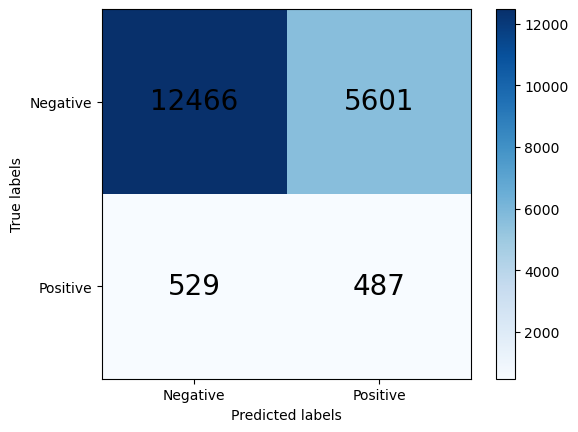

In [14]:
score_selected_columns(selectors=selectors, should_oversample=True)

#### `Comments`

In [15]:
# Without Oversampling, results look really bad.
# With Oversampling, results are better but overall less interesting than those seen on the previous lab (lab-handling-data-imbalance-classification).
# We are going to continue with colomns selected by Chi2